# Functional Transformations

In [1]:
from pathlib import Path

from imgtools.io import read_dicom_auto
from imgtools.ops.functional import (
    bounding_box,
    centroid,
    clip_intensity,
    crop,
    crop_to_mask_bounding_box,
    image_statistics,
    min_max_scale,
    resample,
    resize,
    rotate,
    standard_scale,
    window_intensity,
    zoom,
)

In [2]:
image_path = Path.cwd().parent.parent.parent / 'data/Head-Neck-PET-CT/HN-CHUS-052/08-27-1885-CA ORL FDG TEP POS TX-94629/3.000000-Merged-06362'

# mask path used later in the notebook 
mask_path = Path.cwd().parent.parent.parent / 'data/Head-Neck-PET-CT/HN-CHUS-052/08-27-1885-CA ORL FDG TEP POS TX-94629/1.000000-RTstructCTsim-PETPET-CT-87625'

example_scan = read_dicom_auto(image_path.as_posix())
example_image = example_scan.image

In [3]:
from imgtools.datasets import example_data_paths
from SimpleITK import ReadImage
paths = example_data_paths()

example_image = ReadImage(paths['duck'])
example_mask = ReadImage(paths['mask'])

## Helpers

A set of helper functions to aid in the demo.

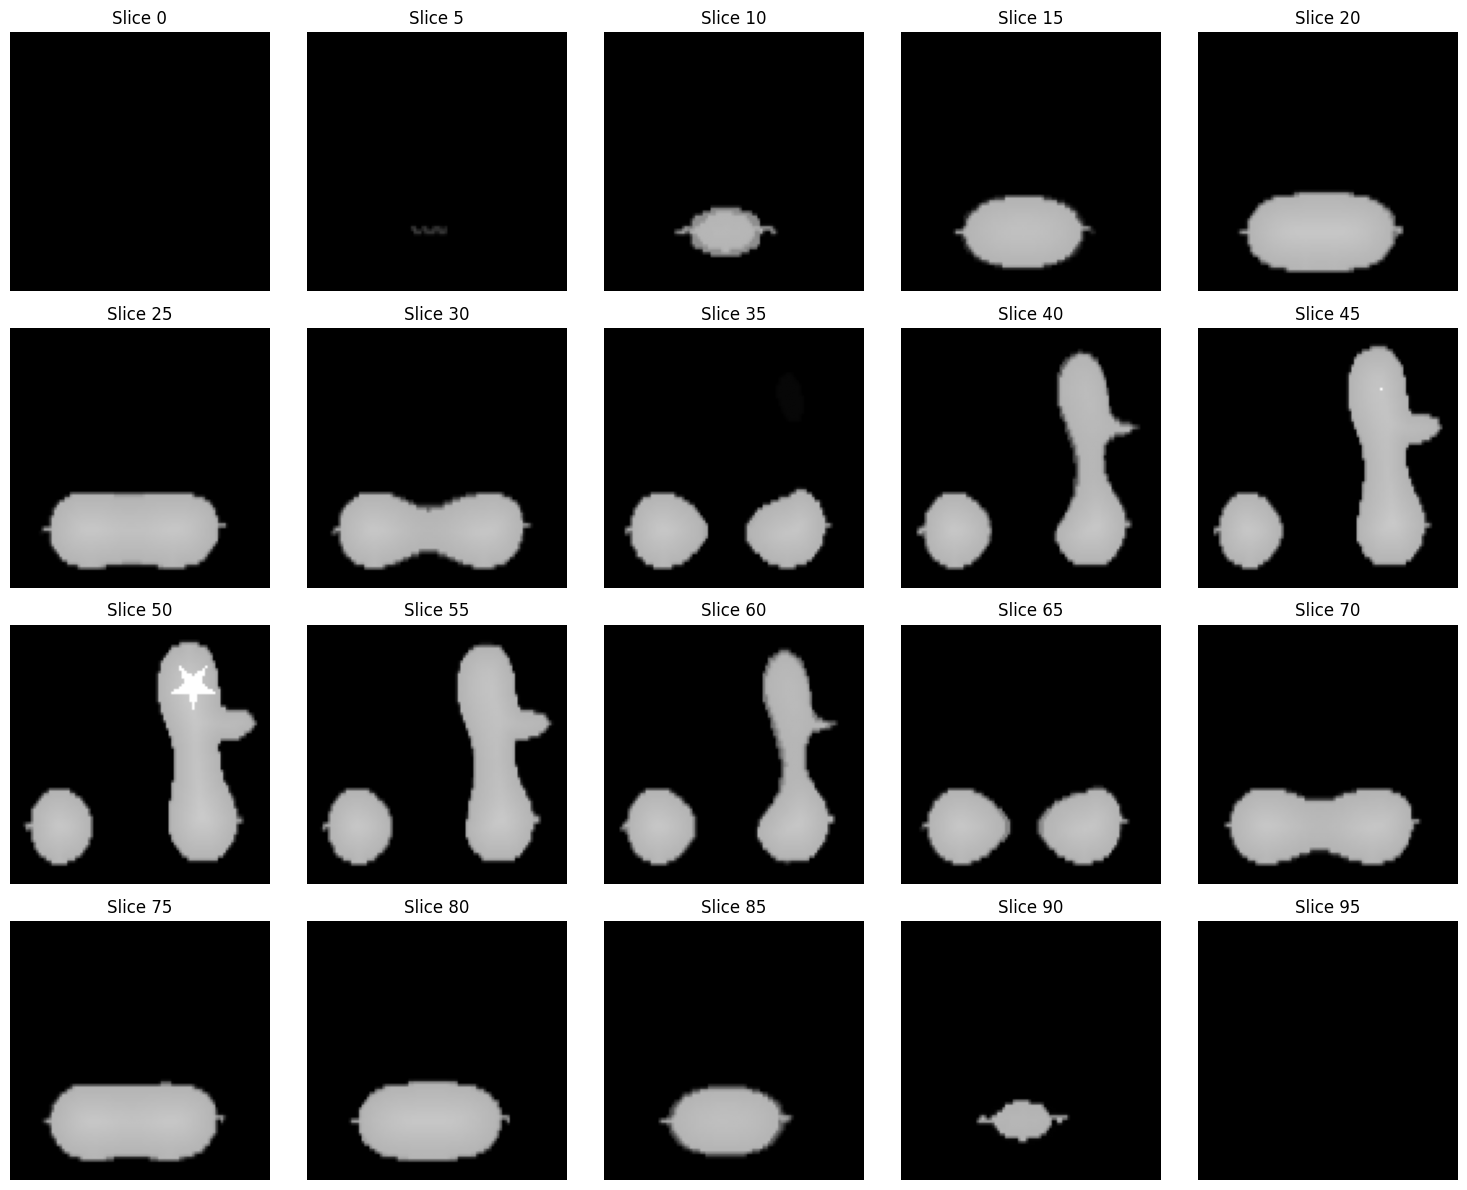

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


def visualize_3d_slices_adaptive(image: sitk.Image, axis: int = 0, step: int = 1, cmap='gray') -> None:
    """
    Visualizes every n-th slice of a 3D SimpleITK image along a specified axis in an adaptive grid layout.

    Args:
        image (sitk.Image): The 3D SimpleITK image to visualize.
        axis (int): The axis along which to slice (0: x, 1: y, 2: z).
        step (int): The step size for selecting slices. Defaults to 1 (every slice).
    """
    array = sitk.GetArrayFromImage(image)
    num_slices = array.shape[axis]
    selected_slices = range(0, num_slices, step)
    num_selected_slices = len(selected_slices)

    vmax = array.max()
    vmin = array.min()

    # Calculate adaptive grid size
    cols = math.ceil(math.sqrt(num_selected_slices))
    rows = math.ceil(num_selected_slices / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()  # Flatten the axes for easy iteration

    for i, slice_index in enumerate(selected_slices):
        if axis == 0:
            slice_ = array[slice_index, :, :]
        elif axis == 1:
            slice_ = array[:, slice_index, :]
        elif axis == 2:
            slice_ = array[:, :, slice_index]

        slice_rotated = np.rot90(slice_, k = 2)

        axes[i].imshow(slice_rotated, cmap, vmax=vmax, vmin=vmin)
        axes[i].set_title(f'Slice {slice_index}')
        axes[i].axis('off')

    # Turn off unused axes
    for ax in axes[num_selected_slices:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_3d_slices_adaptive(example_image, axis=2, step=5)

# Image Statistics

In [5]:
image_statistics(example_image)

ImageStatistics(minimum=0.0, maximum=255.0, sum=24488459.0, mean=24.488459, variance=3802.7554795607984, standard_deviation=61.666485870047744)

# Image Transformations

## Resample

Original Spacing: (1.0, 1.0, 1.0)
Original Size: (100, 100, 100)
Resampled Spacing: (1.0, 1.0, 1.0)
Resampled Size: (128, 128, 128)


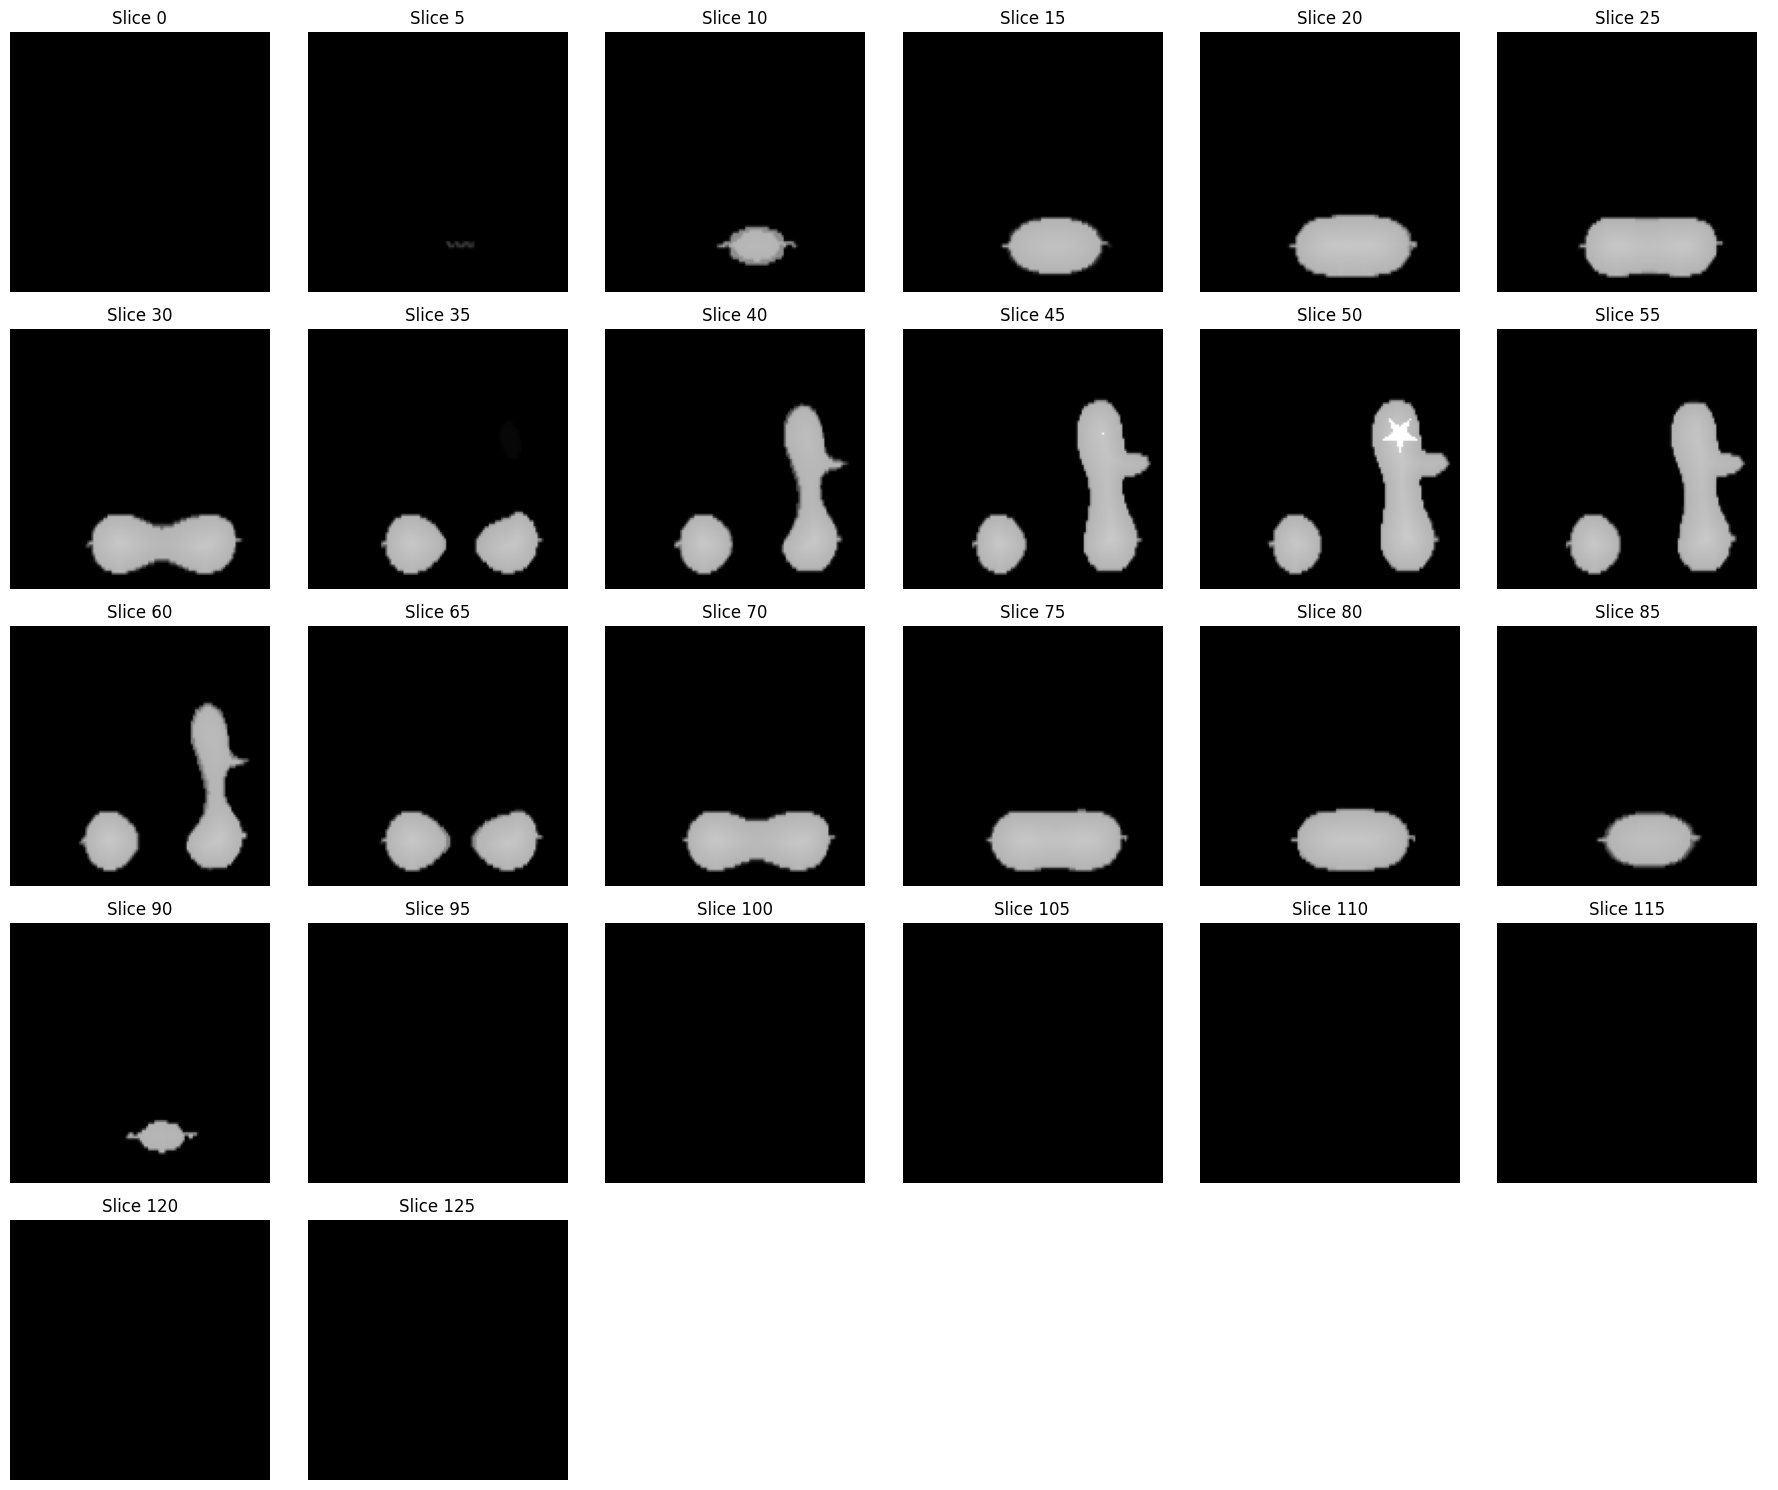

In [6]:
print('Original Spacing:', example_image.GetSpacing())
print('Original Size:', example_image.GetSize())

resampled_image = resample(example_image, [1, 1, 1], output_size=[128, 128, 128])
print('Resampled Spacing:', resampled_image.GetSpacing())
print('Resampled Size:', resampled_image.GetSize())

visualize_3d_slices_adaptive(resampled_image, axis=2, step=5)

## Resize

Original Size: (100, 100, 100)
Resized Size: (256, 256, 100)


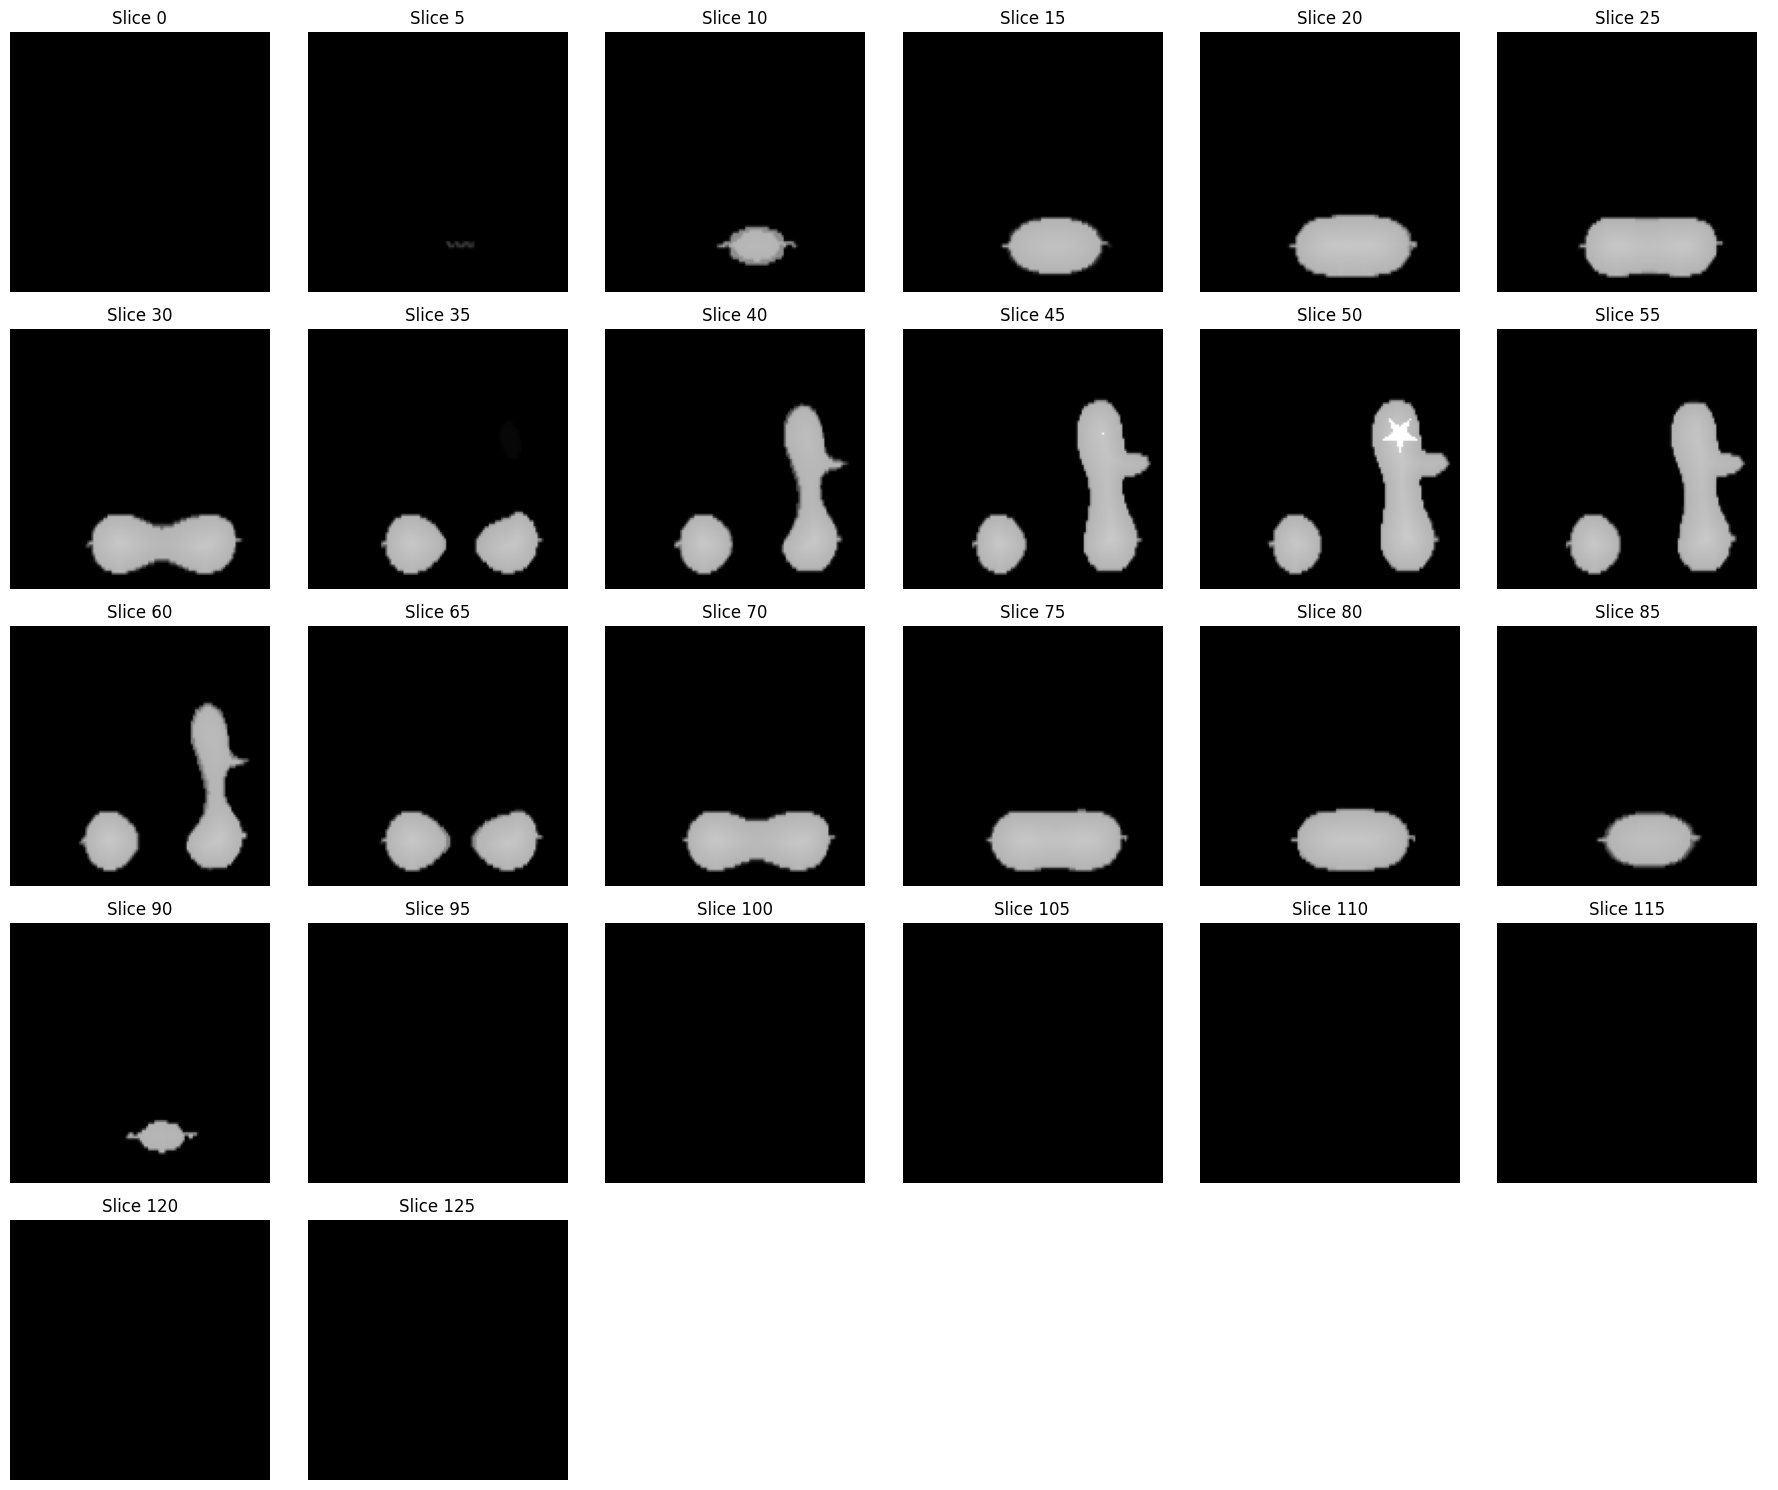

In [7]:
print('Original Size:', example_image.GetSize())
resized_image = resize(example_image, [256, 256, 0])
print('Resized Size:', resized_image.GetSize())

visualize_3d_slices_adaptive(resampled_image, axis=2, step=5)

## Zoom

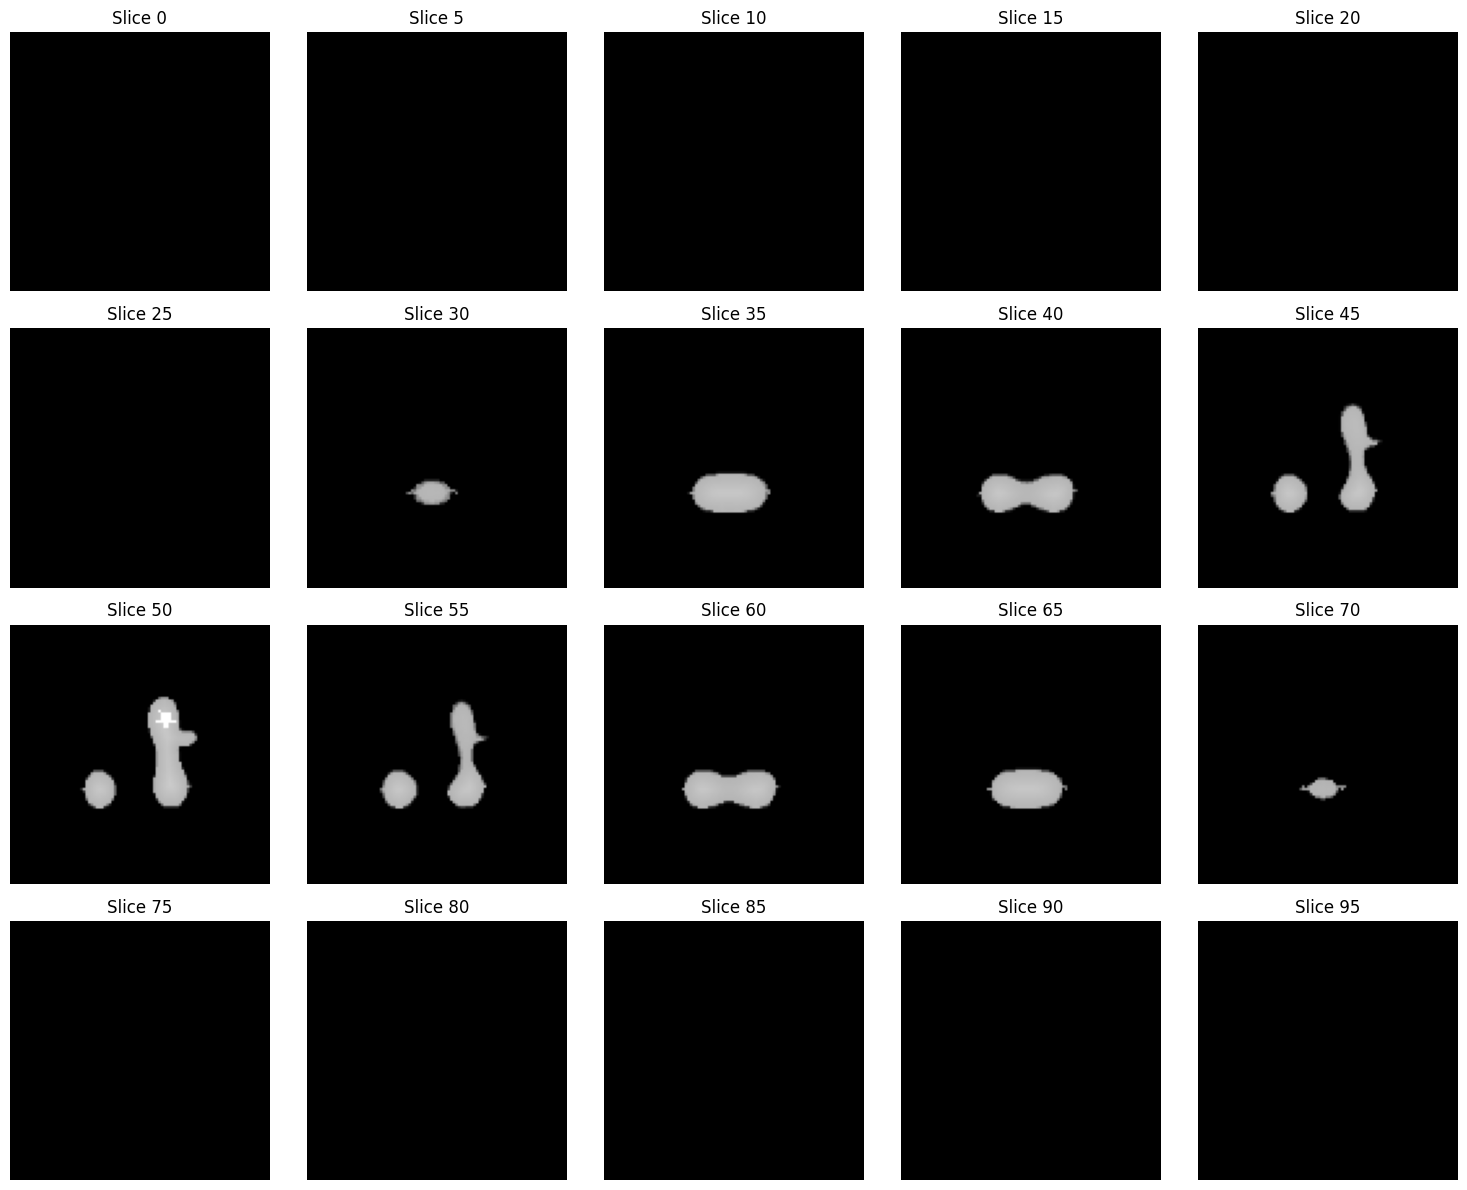

In [8]:
zoomed_image = zoom(example_image, 2.0)

visualize_3d_slices_adaptive(zoomed_image, axis=2, step=5)

## Rotate

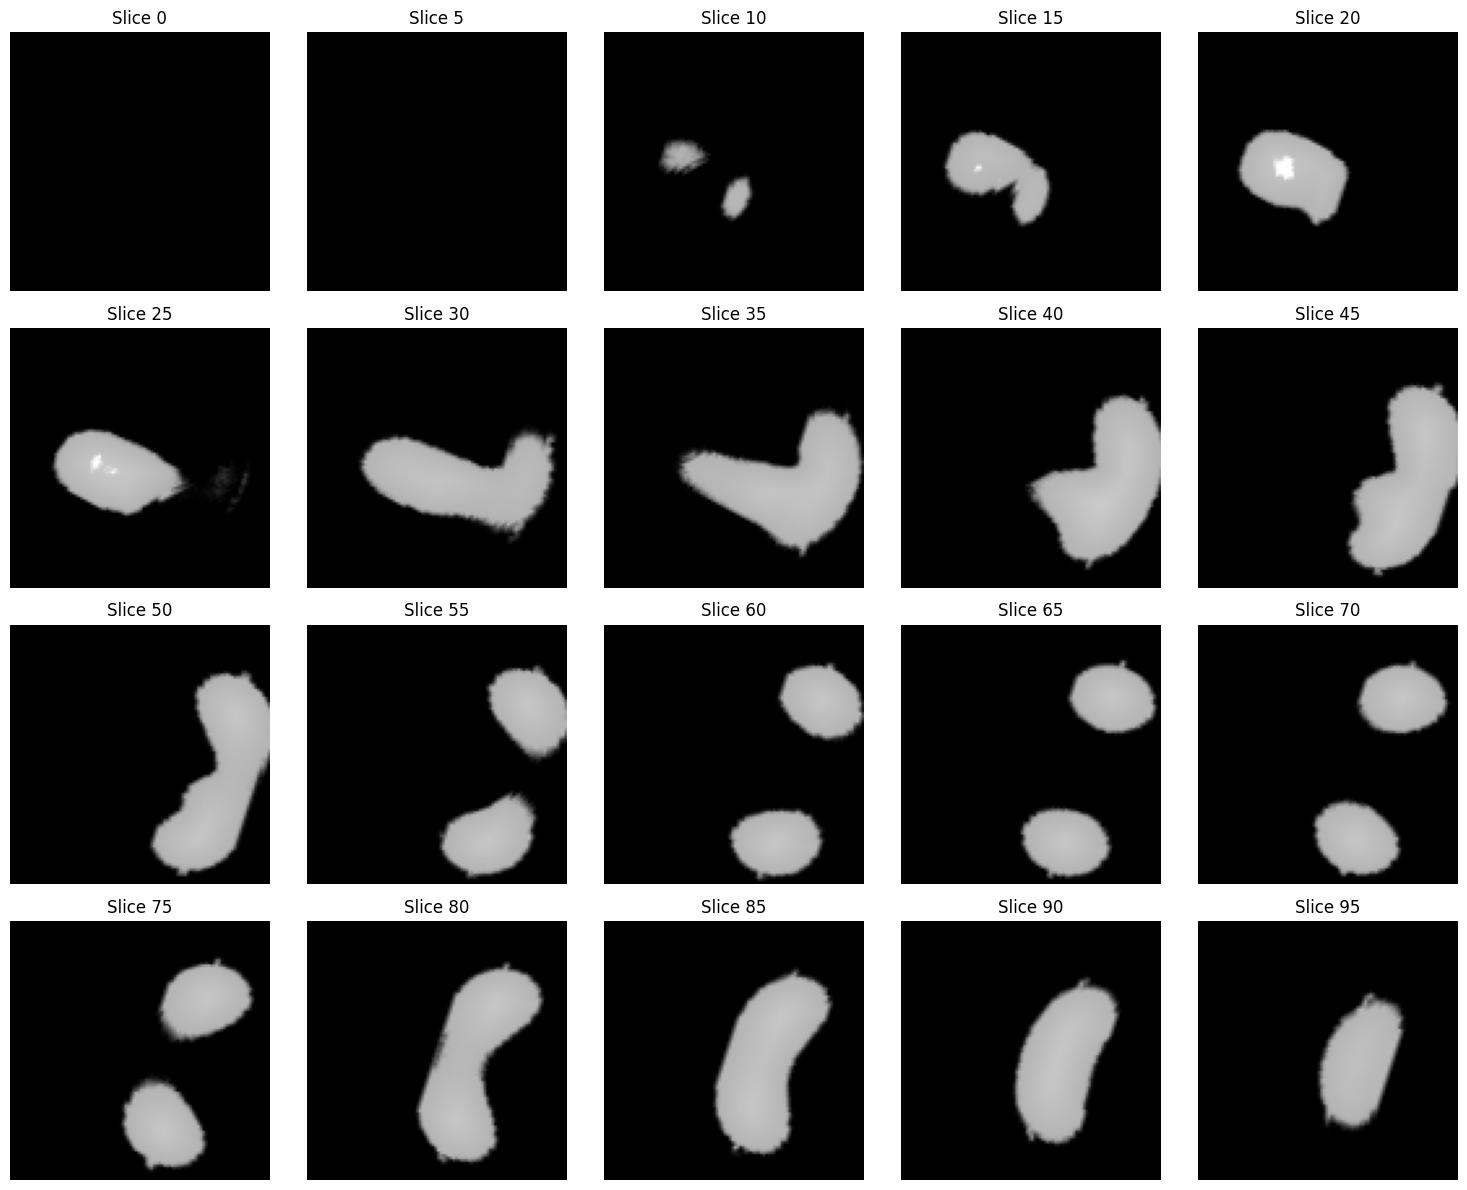

In [9]:
size = example_image.GetSize()
center_voxel = [size[i] // 2 for i in range(len(size))]

rotated_image = rotate(example_image, center_voxel, [45, 45, 45])

visualize_3d_slices_adaptive(rotated_image, axis=2, step=5)

## Crop

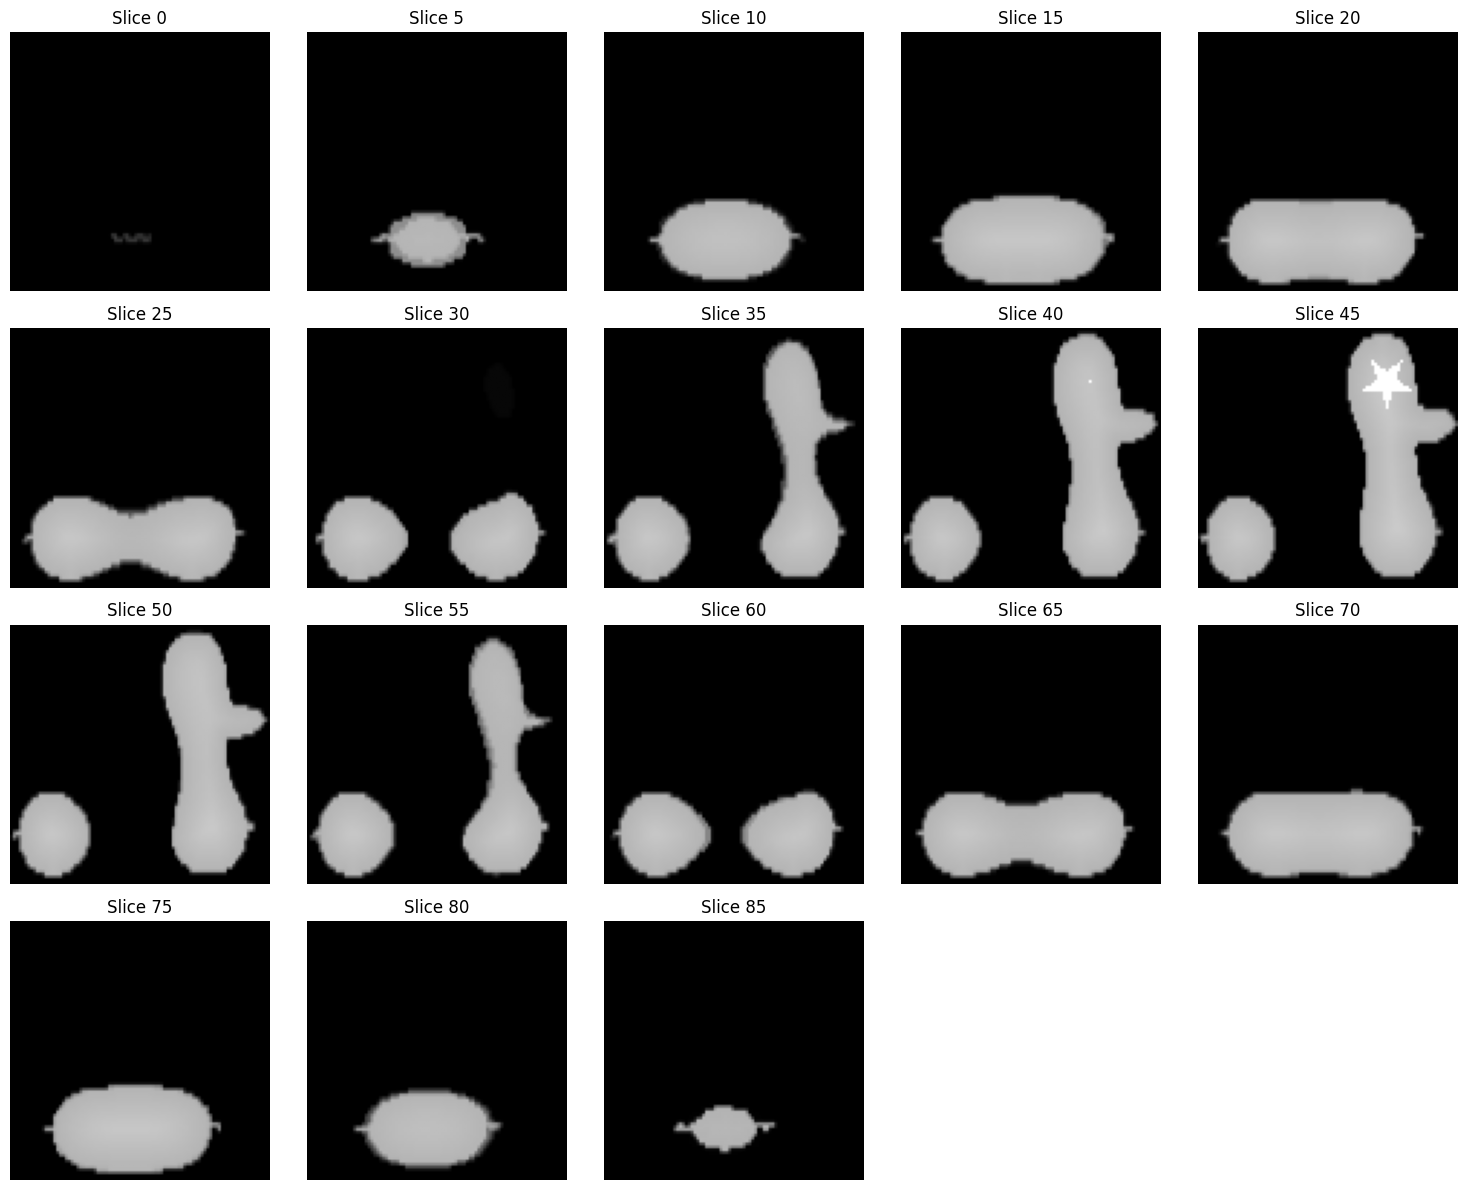

In [10]:
cropped_image = crop(example_image, [50, 50, 50], [90, 90, 90])

visualize_3d_slices_adaptive(cropped_image, axis=2, step=5)

# Mask Transformations

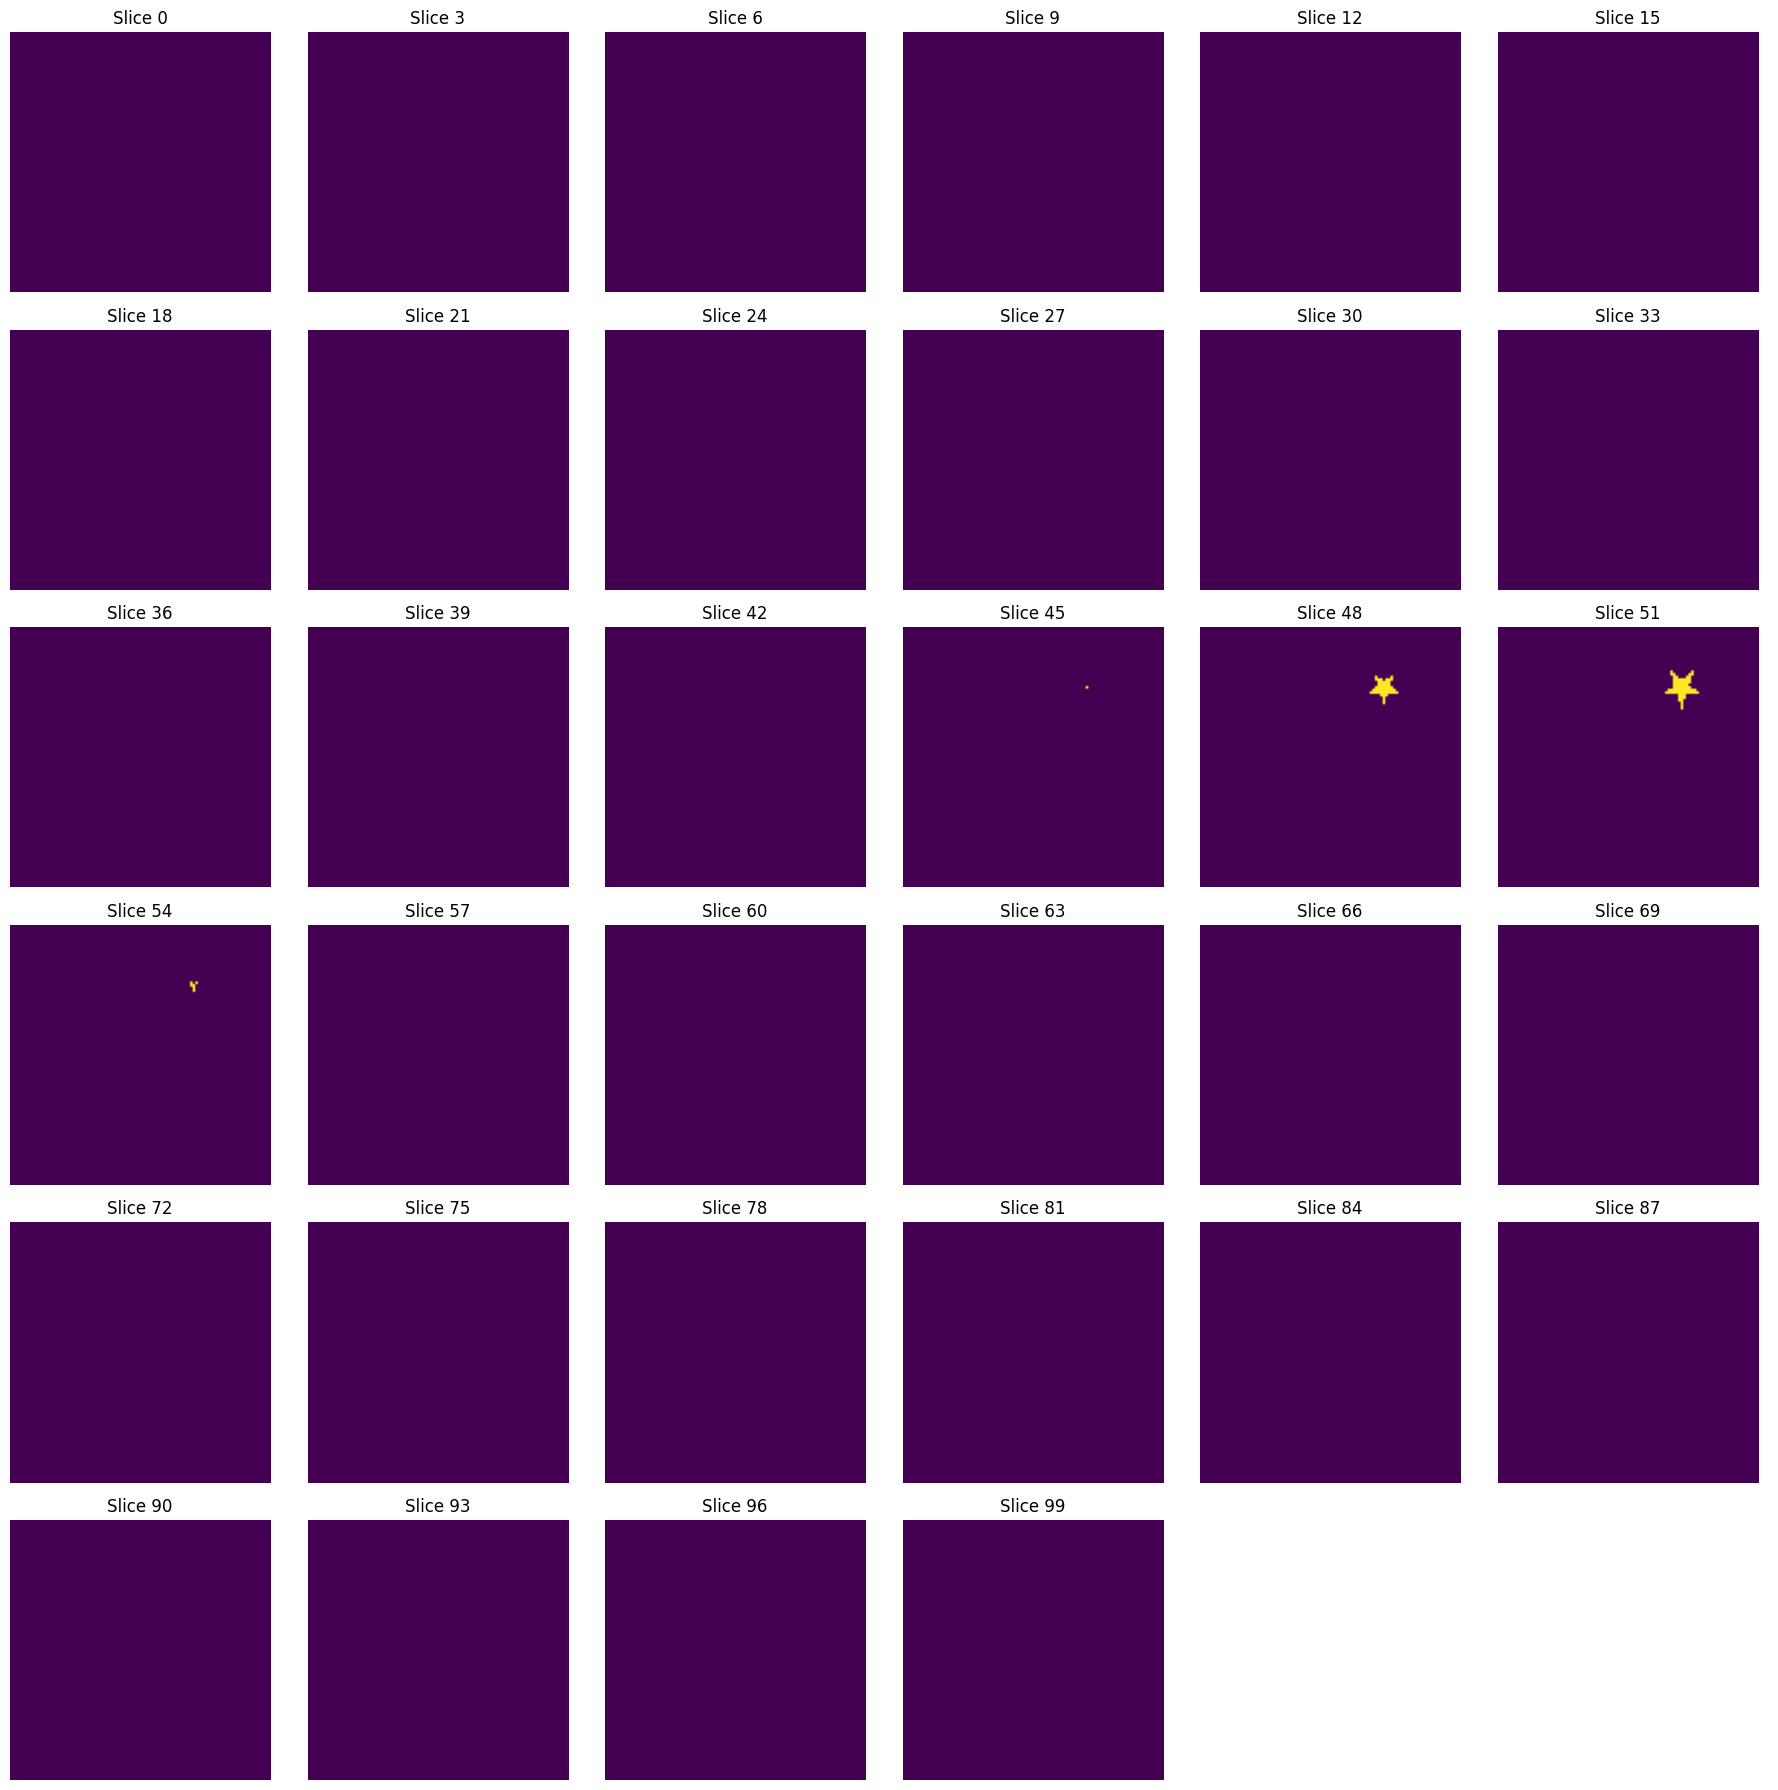

In [16]:
mask = example_mask
visualize_3d_slices_adaptive(mask, axis=2, step=3, cmap=None)

## Centroid

In [12]:
centre_coords = centroid(mask)
print(centre_coords)

(50, 29, 76)


## Bounding Box

In [13]:
box_coords = bounding_box(mask)
print(box_coords)

((45, 21, 67), (10, 17, 17))


## Crop to Bounding Box

[np.float64(50.0), np.float64(29.5), np.float64(75.5)]


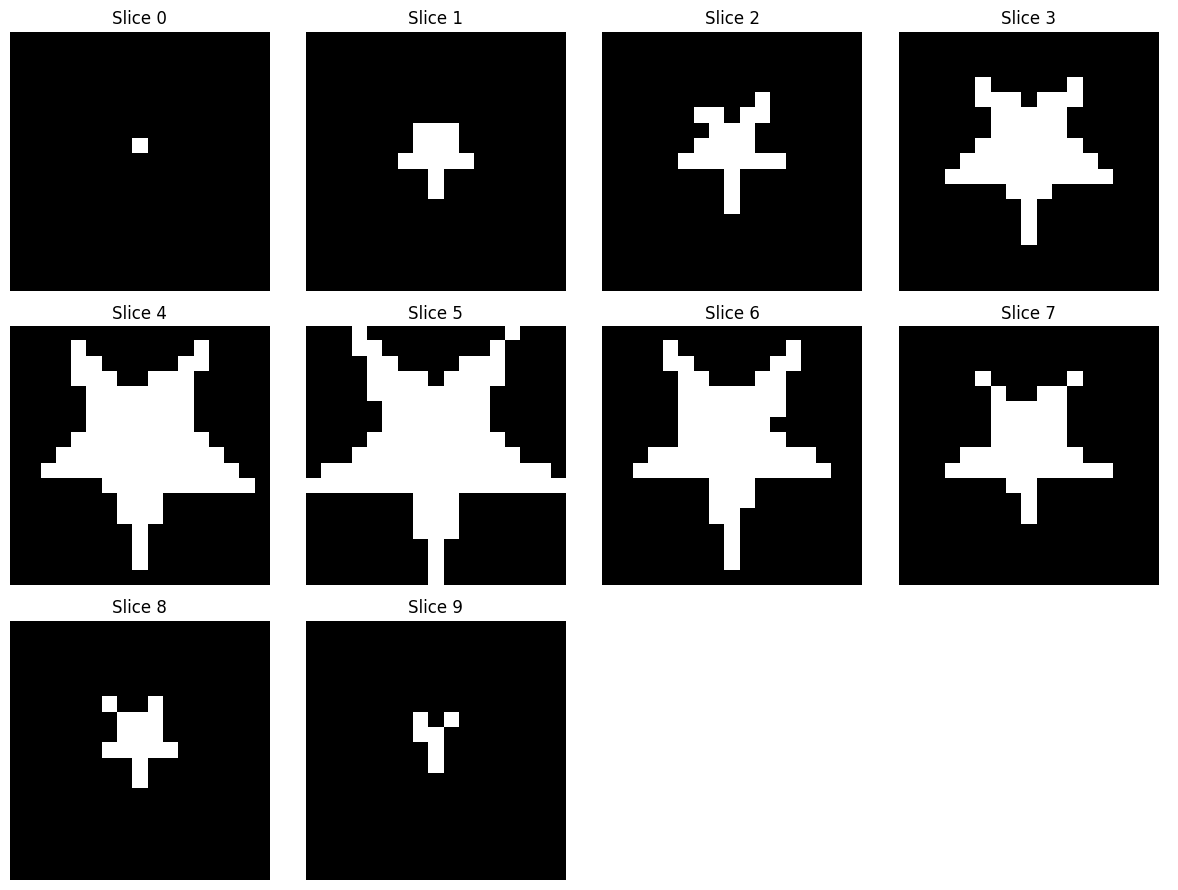

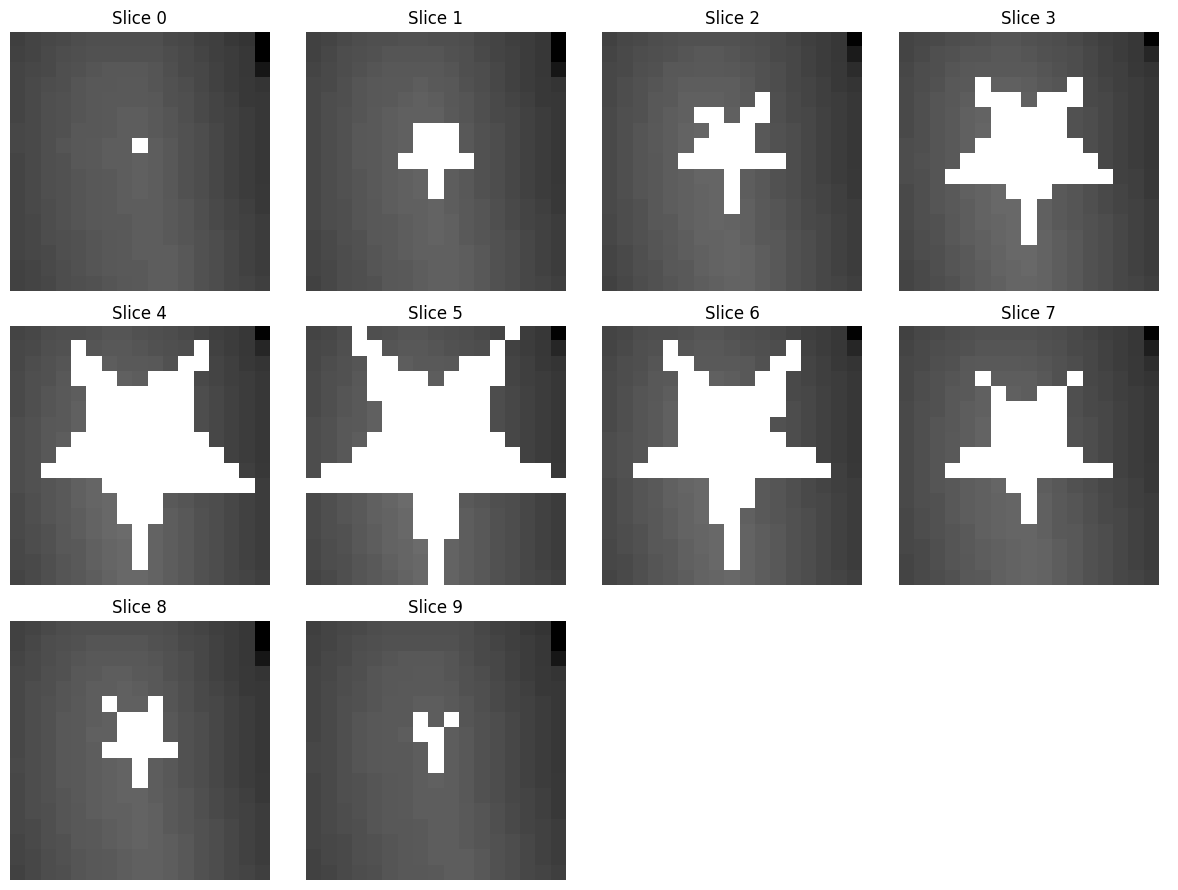

In [14]:
cropped_image, cropped_mask, crop_centre = crop_to_mask_bounding_box(example_image, mask)
print(crop_centre)

visualize_3d_slices_adaptive(cropped_mask, axis=2, step=1)
visualize_3d_slices_adaptive(cropped_image, axis=2, step=1)

# Intensity Transformations

## Clip Intensity

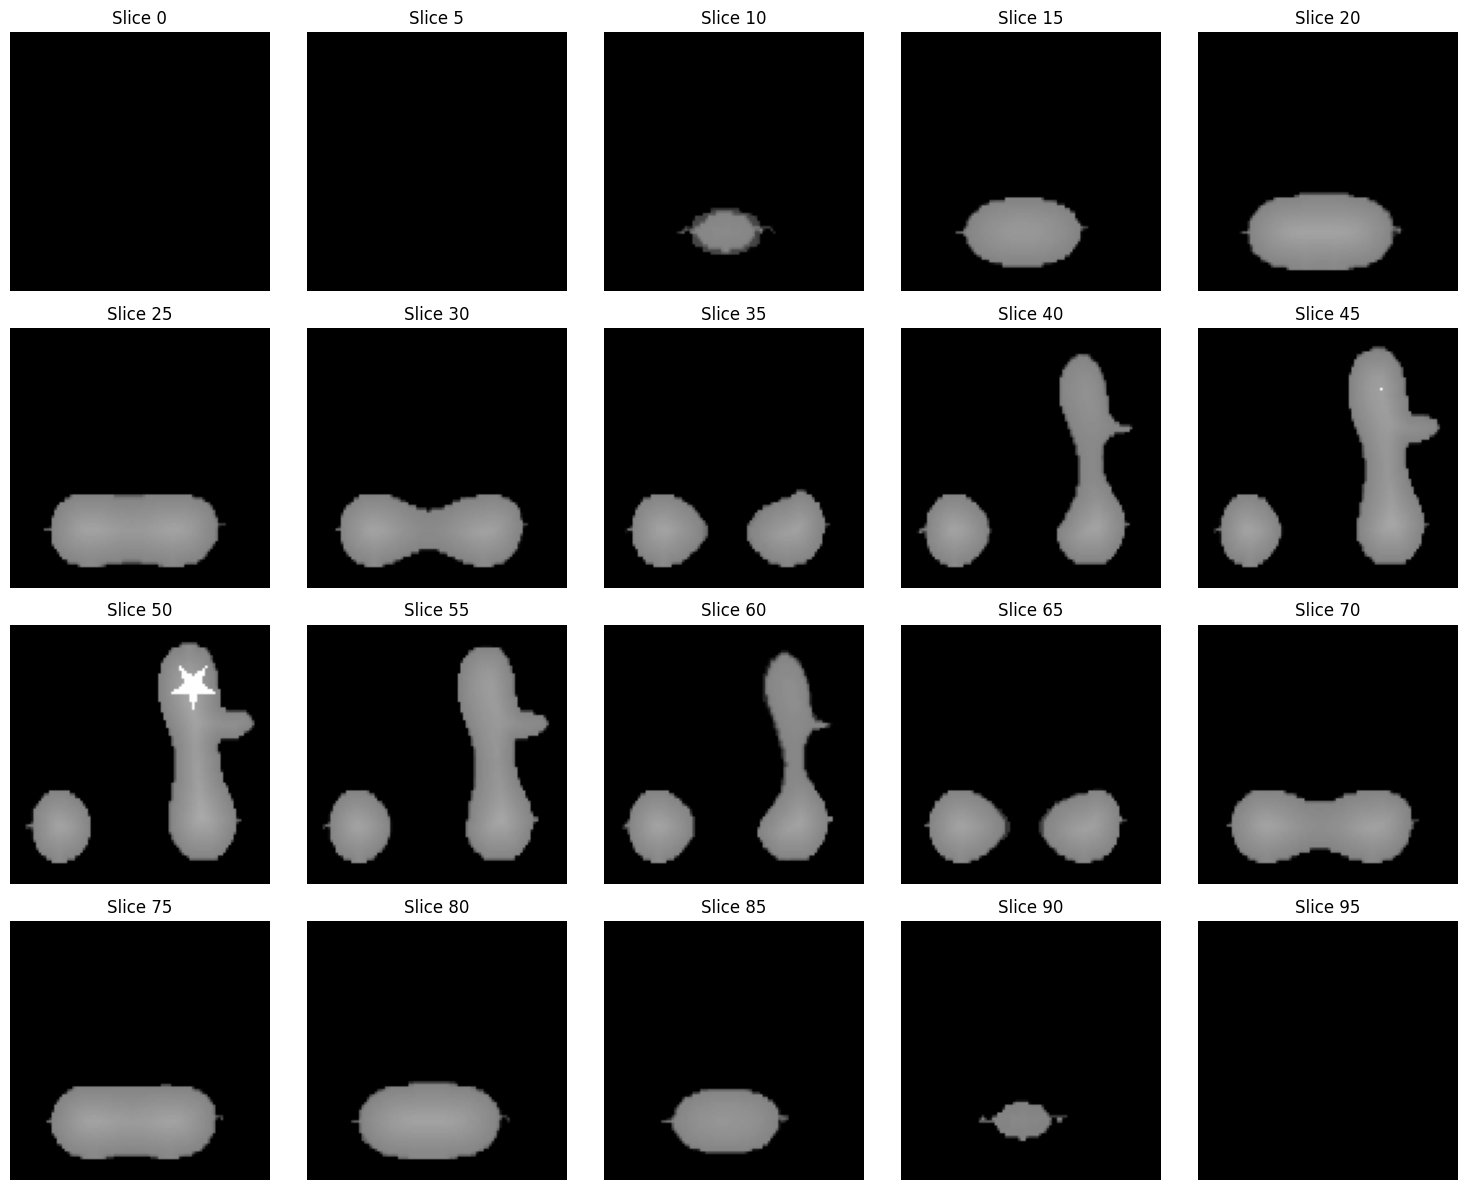

In [17]:
clipped_image = clip_intensity(example_image, lower=100, upper=255)

visualize_3d_slices_adaptive(clipped_image, axis=2, step=5)

## Window Intensity

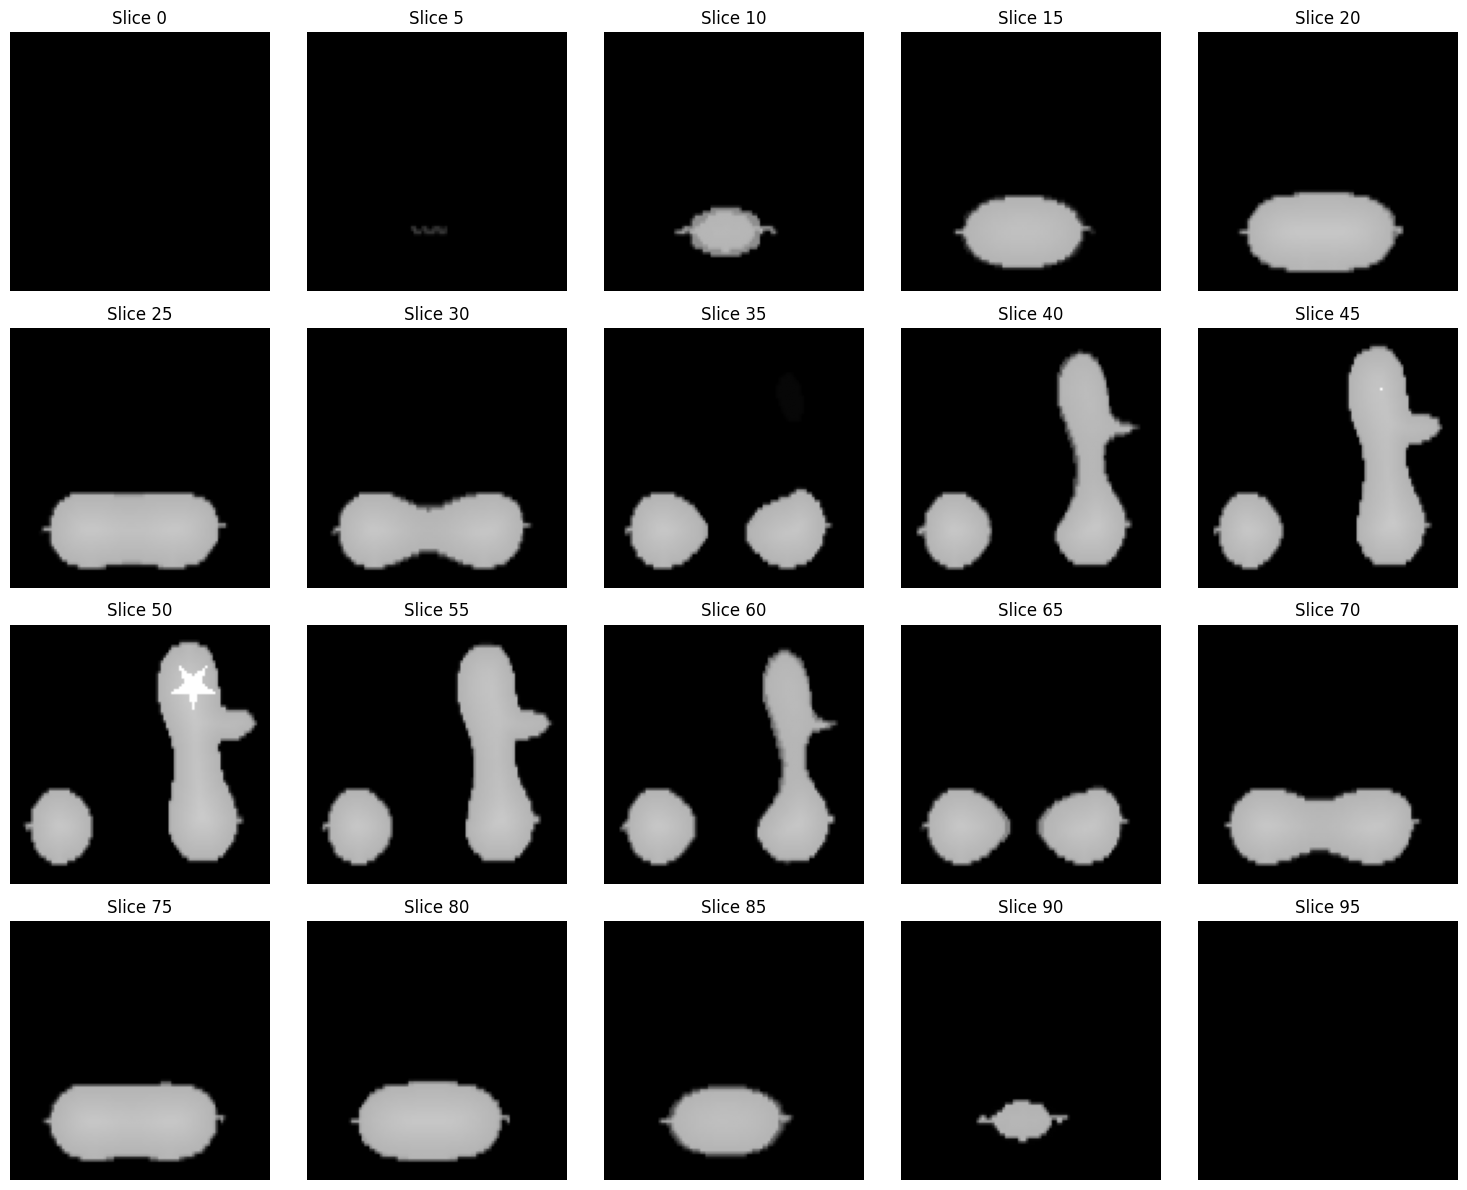

In [18]:
windowed_image = window_intensity(example_image, 1500, 0)

visualize_3d_slices_adaptive(windowed_image, axis=2, step=5)

## Min-max Normalization

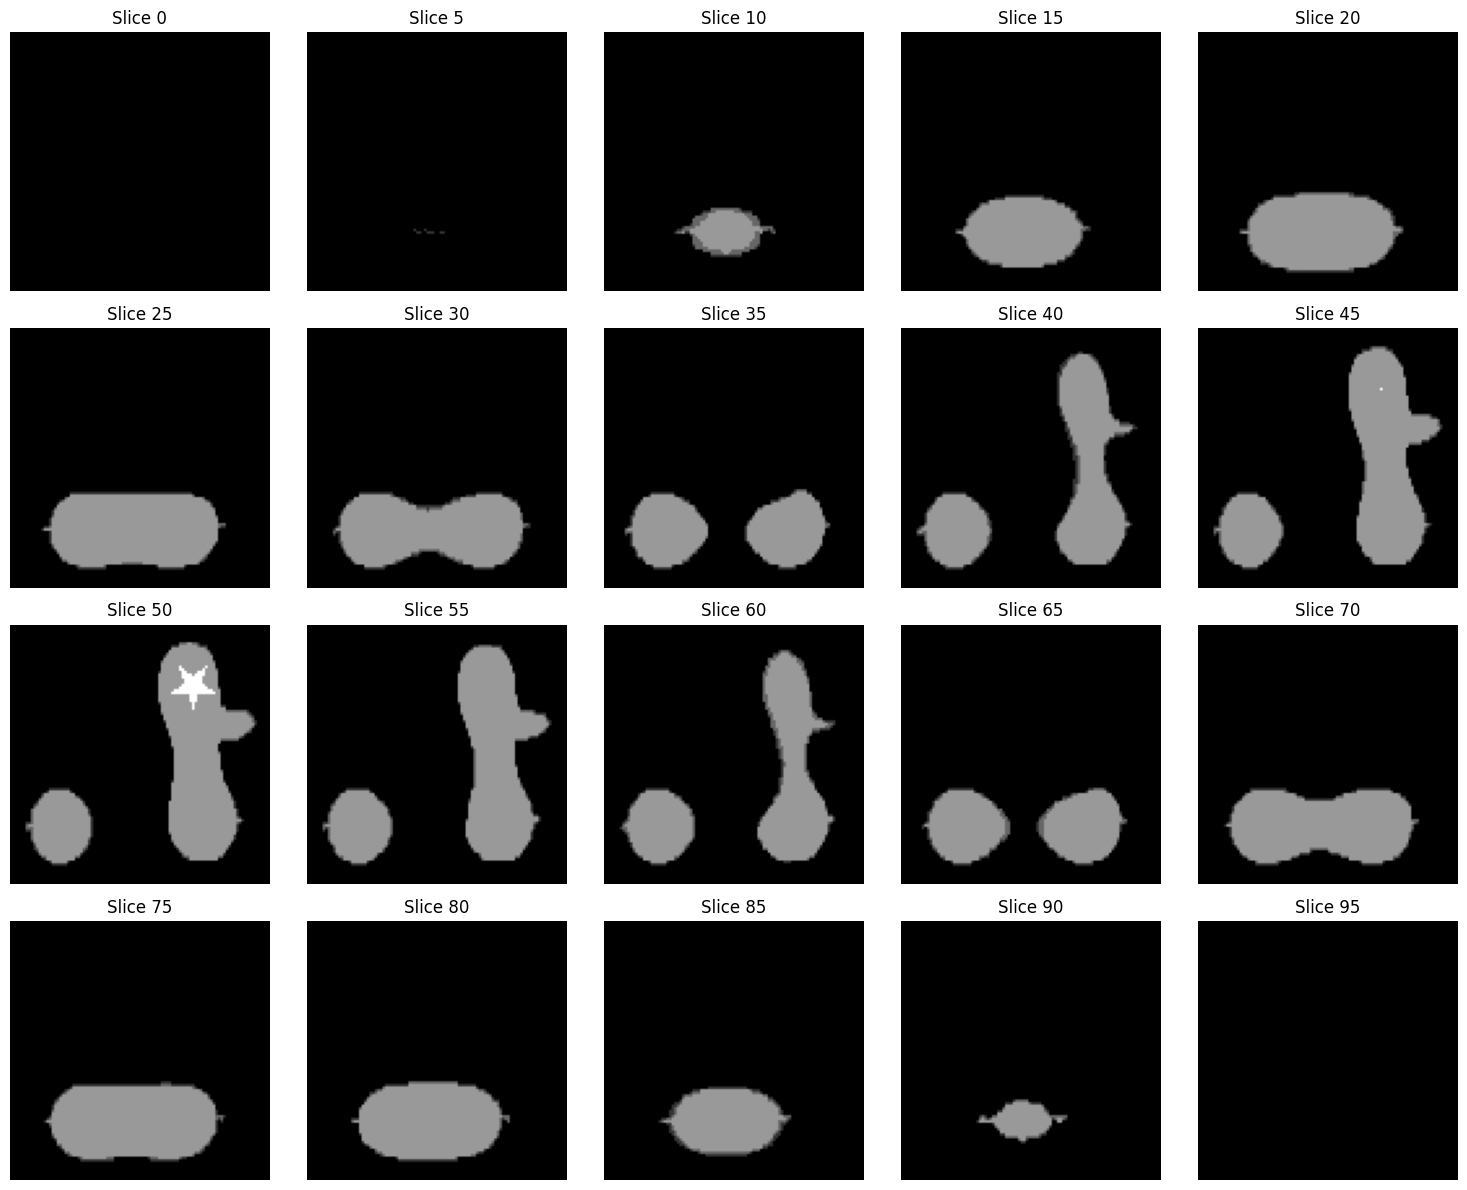

In [20]:
min_max_image = min_max_scale(example_image, minimum=0, maximum=5)

visualize_3d_slices_adaptive(min_max_image, axis=2, step=5)

## Standardization

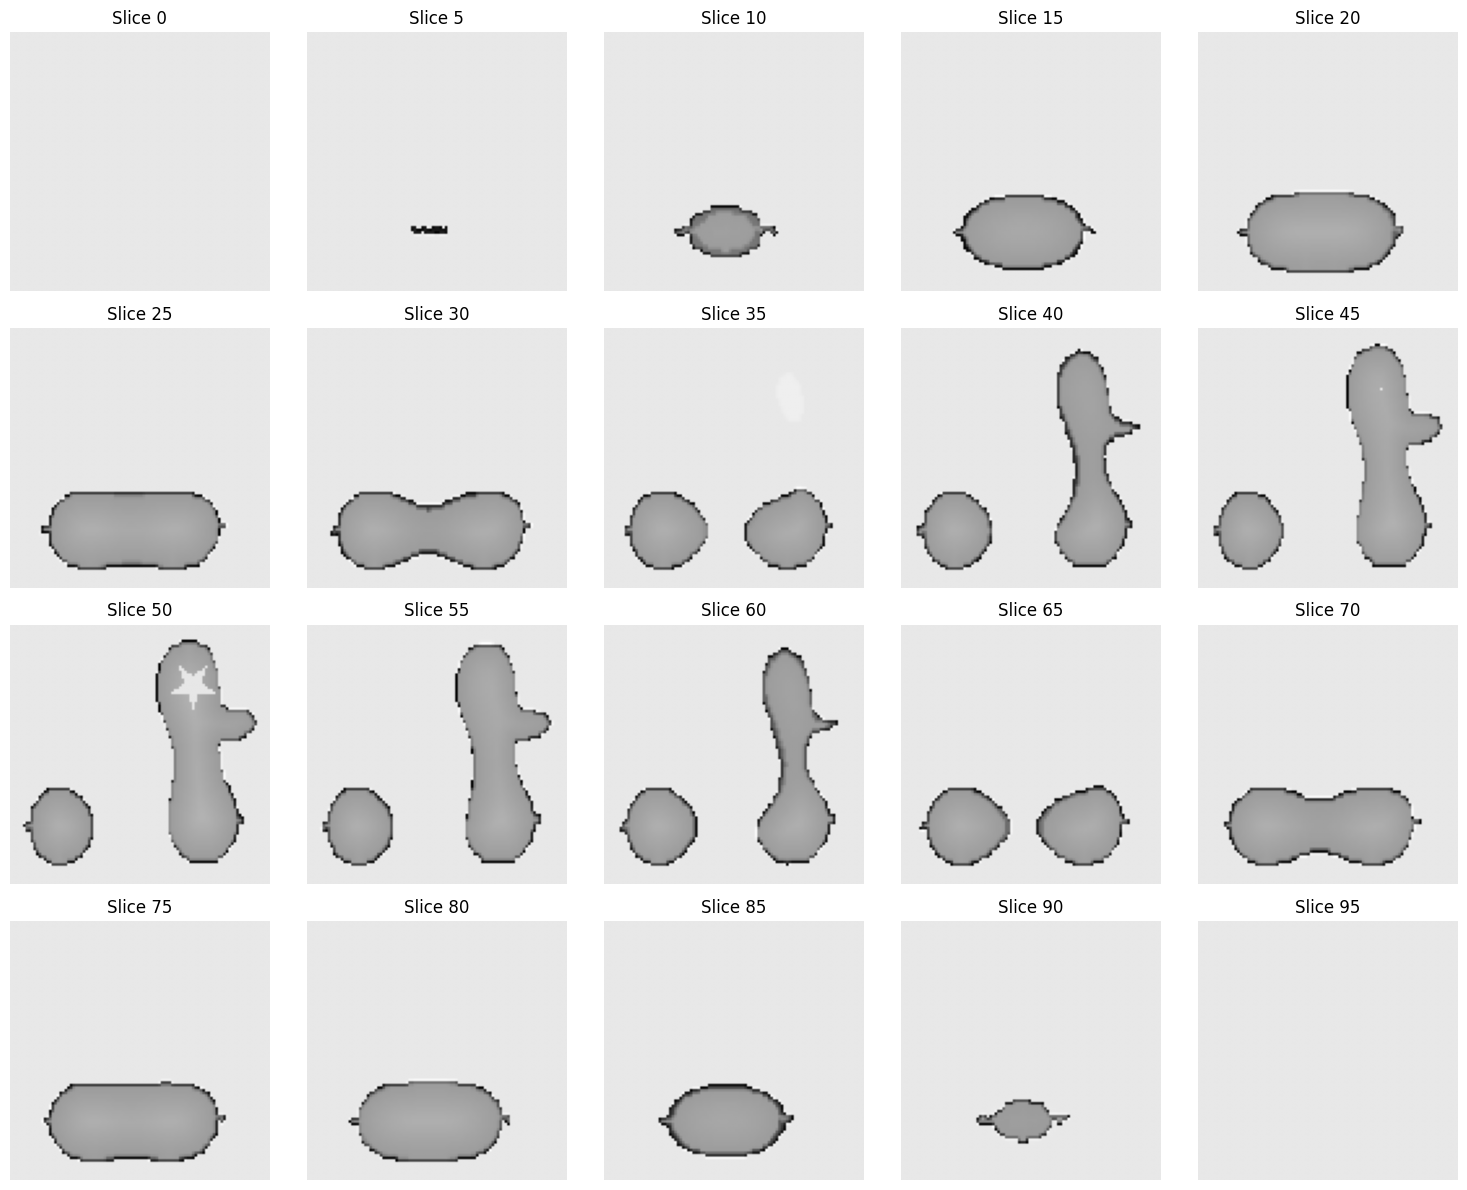

In [21]:
standardized_image = standard_scale(example_image)

visualize_3d_slices_adaptive(standardized_image, axis=2, step=5)